In [2]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import network_module as nm
import argparse

def print_csv(filename, data):
    with open(filename, 'wb') as out:
        for t in data:
            out.write('{}\t{}\n'.format(*t))


# layer_params = sys.argv[1:]

# netname = 'mnist-fc-784-'
# for width in layer_params:
#     netname += '{}-'.format(width)
# netname += '10'
reg = 0
L1 = False
L2 = False
L05 = False
netname = 'conv5-3x3-maxpool-100'
data_source = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

def loadmnist():
    import cPickle, gzip, numpy

    # Load the dataset
    f = gzip.open('./MNIST_data/mnist.pkl.gz', 'rb')
    sets = cPickle.load(f)
    f.close()
    res = []
    for set in sets:
        set[0].shape = (-1, 1, 28, 28)

        label = set[1]
        onehot = np.zeros((label.size, label.max() + 1))
        onehot[np.arange(label.size), label] = 1
        res.append((set[0].reshape(-1, 1, 28, 28), onehot))
    return res


print 'Loading MNIST images...'
train, test, _= loadmnist()


# train = (np.zeros((50, 1, 20, 20)), np.zeros((50 ,1 ,8 , 8)))
# train[0][0,:,5,5] = 0.5
# train[1][0,:,4,4] = 1

def loadnetwork(network_source):
    global nn
    nn = nm.load(network_source)


print 'Constructing network...'
#########################
# NETWORK DEFINITION
def init():
    global nn
    nn = nm.network(in_shape=train[0][0].shape, criterion='MSE')
    nn.add_conv(kernel_shape=(3,3), num_of_ker=1)

#########################
init()
print nn
    
def imshow(im, cmap='Greys', interpol='None'):
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if len(im.shape) == 3:
        for i, x in enumerate(im, 1):
            plt.subplot(1, len(im), i)
            plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
    if len(im.shape) == 4:
        for irow, xrow in enumerate(im, 0):
            for icol, x in enumerate(xrow, 1):
                # print '\r  ', len(im), len(xrow), irow * len(xrow) + icol
                plt.subplot(len(im), len(xrow), irow * len(xrow) + icol)
                plt.imshow(x.squeeze(), cmap=cmap, interpolation=interpol)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.show()
    return im.shape


def visualise_layer(layer_ind=4, top=9, epoch=10, activation_set=train[0], biased=False, rate=0.05):
    test = nn.grad_ascent(
        layer_ind=layer_ind, 
        activation_set=activation_set, 
        top=top, 
        epoch=epoch, 
        biased=biased)
    test = test.reshape((top,) + nn[layer_ind].shape + (28, 28))
    test = np.concatenate((test, test.mean(axis=0)[np.newaxis, :]), axis=0)
    return test

def max_act(lay_ind, top=9):
    return test[0][nn.max_act(lay_ind, test[0], top)].squeeze()



Loading MNIST images...
Constructing network...
Network ID: 140662992479568
Network layout:
------------------------------
	INPUT  (1, 28, 28)
	   |
	   |
	  |1|
  convolution  (1, 26, 26)   ->   kernels: (1, 1, 3, 3)
	   |
	   |
	  |2|
  	OUTPUT  (1, 26, 26)   ->   CRITERION  (MSE)
------------------------------


550.300208388
[[[[[ 186.66  178.05  189.16]
    [ 166.4   119.2   151.34]
    [ 191.56  178.93  176.54]]]]]
186.657831342
[-0.36]


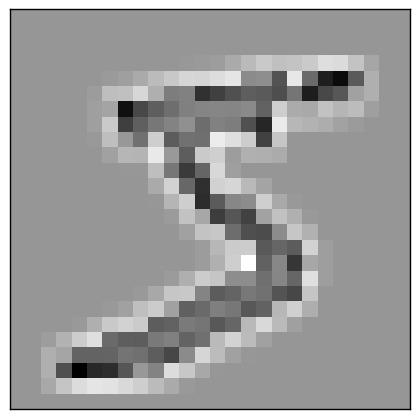

(1, 26, 26)

In [4]:
from scipy.signal import convolve2d
x = train[0][0]
#k = np.zeros((3,3))
#k[1,1] = 1
k = -1*np.ones((3,3))
k[1,1] = 8

#k = np.array([[-2,-1,0],[-1,1,1],[0,1,2]])

y = convolve2d(x[0], k[::-1, ::-1], 'valid')
#imshow(x.reshape(1,28,28))
#imshow(y.reshape(1,26,26))

print(nn.output.get_crit(input=x, target=y))
nn[1].get_delta(y)
p = nn[1].get_param_grad()[0]
print  p
print p[0,0,0,0,0]
print nn[1].bias
imshow(y[None])

In [27]:
np.all(nn[1].output-y == nn[1].delta)
#print nn[1].delta.shape
#np.all(p == convolve2d(x[0], nn[1].delta[0,0], 'valid'))

False

In [5]:
def print_test():
    print nn.output.get_crit(input=x, target=y)
    
def train_net(epoch=10):
  nn.last_epoch = 0
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=(x[np.newaxis], y[np.newaxis, np.newaxis]),
         batch=1, rate=-0.001, 
         epoch_call_back=print_test(),
         epoch=epoch)
    

    
def gradtest(eps):
    print 'AAAAAAAAAAAAAAAAAAAAA'
    X = nn.get_output(x)
    nn[1].kernels[0,0,0,0] += eps
    dxp = nn.output.get_crit(input=x, target=y[None])
    Xp = nn[1].output
    
    nn[1].kernels[0,0,0,0] -= 2 * eps
    dxm = nn.output.get_crit(input=x, target=y[None])
    Xm = nn[1].output
    
    #print 0.5*np.sum((Xp - y[None])**2)
    #print dxp
    #print 0.5*np.sum((Xm - y[None])**2)
    #print dxm
    nn[1].kernels[0,0,0,0] += eps
    print 'BBBBBBBBBBBBBBBBBBBBB'
    res = (dxp-dxm)/(2*eps)
    return res


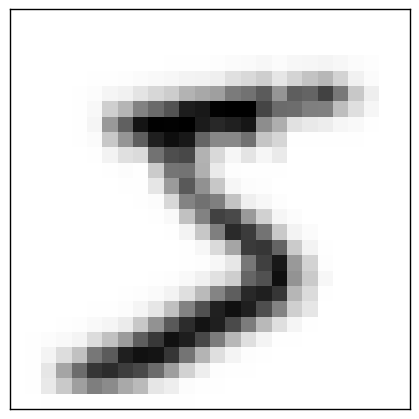

486.304517486
   batch: 1 of 1 
[[[[-1.29 -0.47 -1.37]
   [-0.36  6.97 -0.35]
   [-1.4  -0.41 -1.33]]]]
(array([[[[[-0.39,  0.75, -0.66],
          [ 1.5 , -2.43,  1.57],
          [-0.76,  0.97, -0.55]]]]]), array([-2.04]))


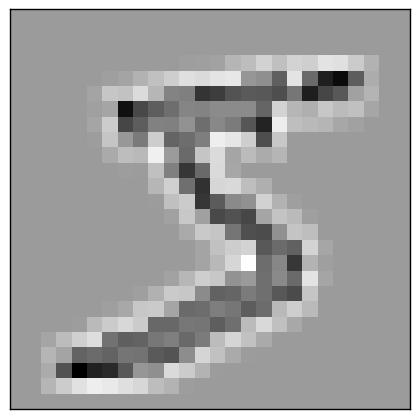

3.14591565883
   batch: 1 of 1 
[[[[-1.12 -0.79 -1.14]
   [-0.78  7.65 -0.78]
   [-1.14 -0.78 -1.12]]]]
(array([[[[[-0.24,  0.42, -0.28],
          [ 0.45, -0.73,  0.46],
          [-0.3 ,  0.46, -0.26]]]]]), array([-1.01]))


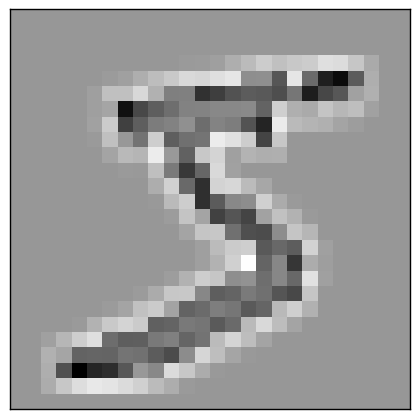

0.391437471636
   batch: 1 of 1 
[[[[-1.04 -0.92 -1.05]
   [-0.92  7.88 -0.92]
   [-1.05 -0.92 -1.04]]]]
(array([[[[[-0.09,  0.16, -0.1 ],
          [ 0.16, -0.26,  0.16],
          [-0.1 ,  0.16, -0.09]]]]]), array([-0.37]))


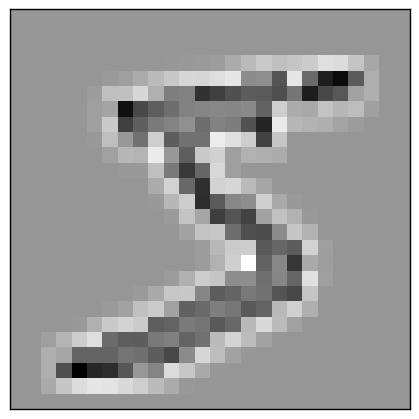

4.6171875
-4.59375
4.60962599799
-4.55631654755


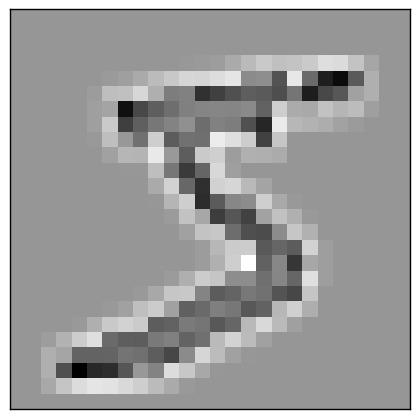

(1, 26, 26)

In [6]:
def print_test():
    print nn.output.get_crit(input=x, target=y)
    
    
def train_net(epoch=10):
  nn.last_epoch = 0
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=(x[np.newaxis], y[np.newaxis, np.newaxis]),
         batch=1, rate=0.001,
         epoch_call_back=print_test(),
         epoch=epoch)
    
init()
#nn[1].kernels[0,0]=np.randn

imshow(nn.get_output(x))
for i in xrange(3):
    train_net(500)
    print''
    print nn[1].kernels
    print nn[1].get_param_grad()
    imshow(nn.get_output(x))
print y.max()    
print y.min()
print nn.get_output(x).max()
print nn.get_output(x).min()
imshow(y[None])

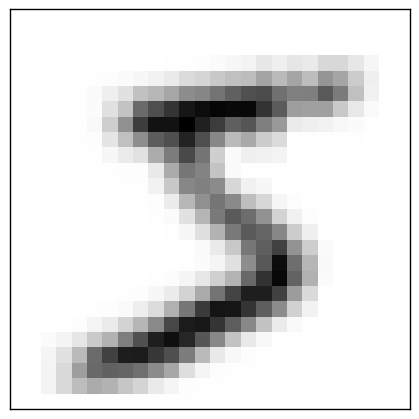

386.2496505
   batch: 1 of 1

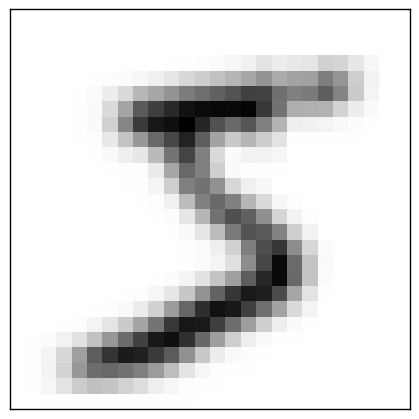

 5140.90212849
   batch: 1 of 1

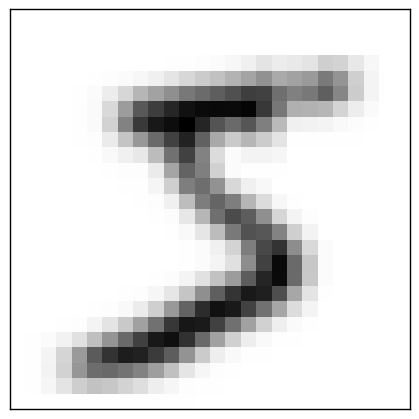

 22534.4771364
   batch: 1 of 1

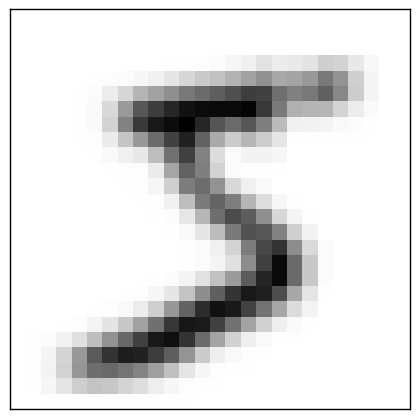

 53370.4311377
   batch: 1 of 1

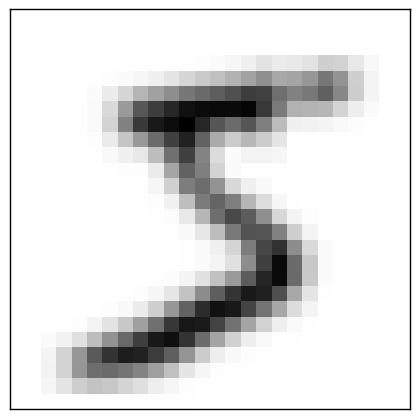

 97732.554546
   batch: 1 of 1

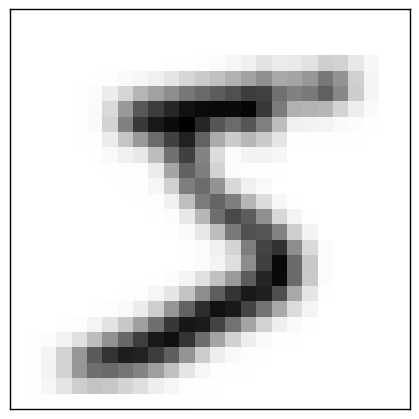

 155661.586408
   batch: 1 of 1

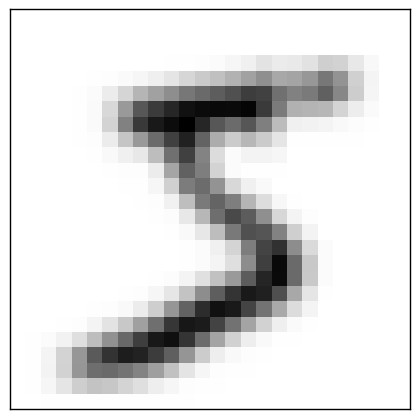

 227153.698716
   batch: 1 of 1

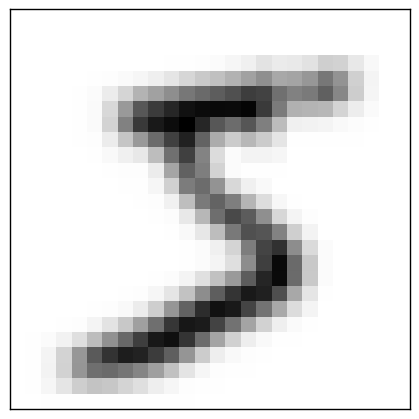

 312201.35819
   batch: 1 of 1

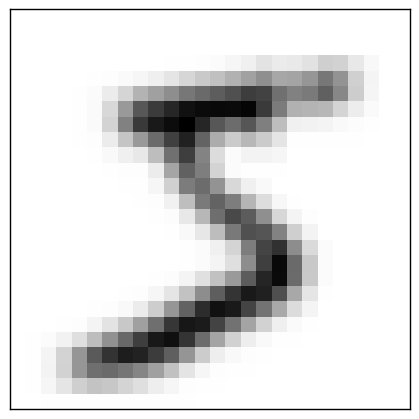

 410808.466532
   batch: 1 of 1

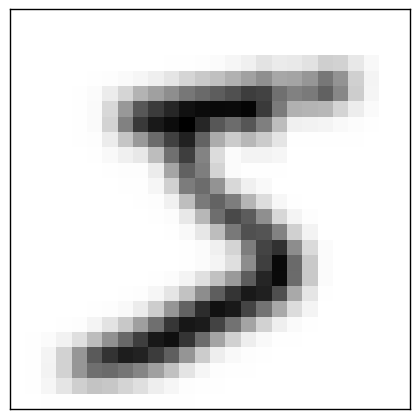

 522993.016382
   batch: 1 of 1

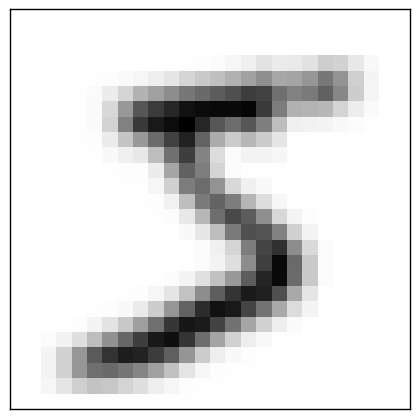

 648770.297344
   batch: 1 of 1

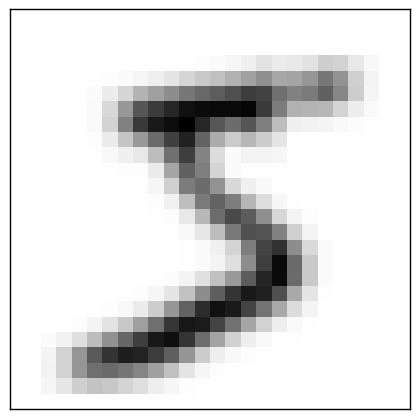

 788144.595942
   batch: 1 of 1

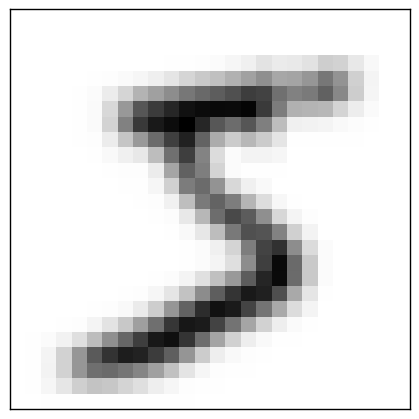

 941118.060231
   batch: 1 of 1

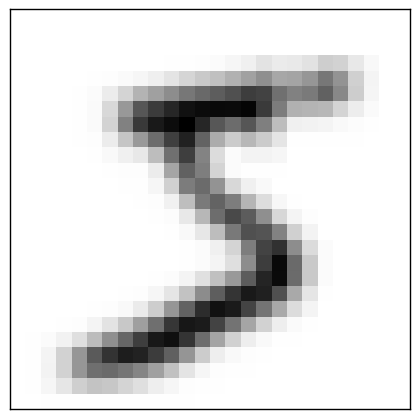

 1107693.30401
   batch: 1 of 1

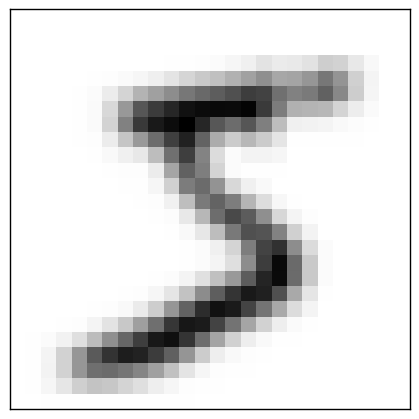

 1287861.20809
   batch: 1 of 1

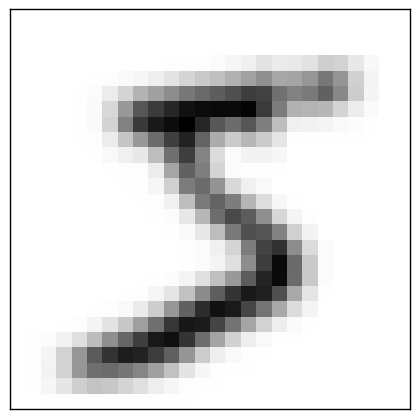

 1481623.94298
   batch: 1 of 1

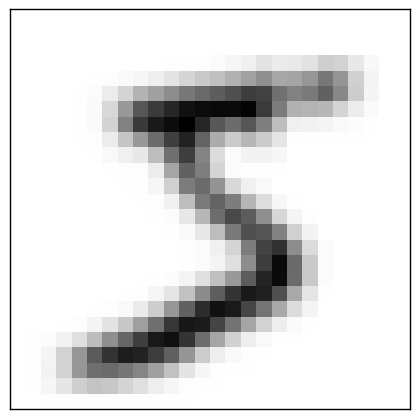

 1688981.11717
   batch: 1 of 1

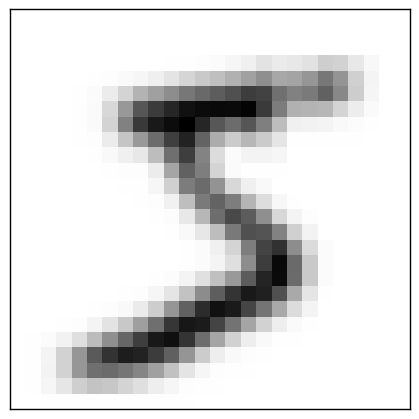

 1909933.11068
   batch: 1 of 1

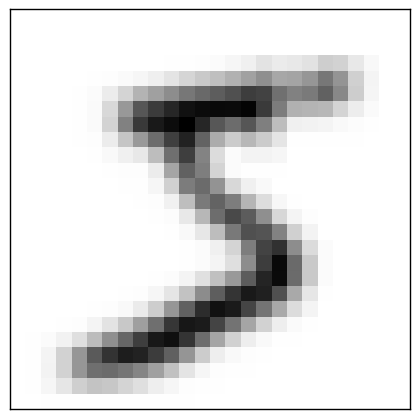

 2144481.32155
   batch: 1 of 1

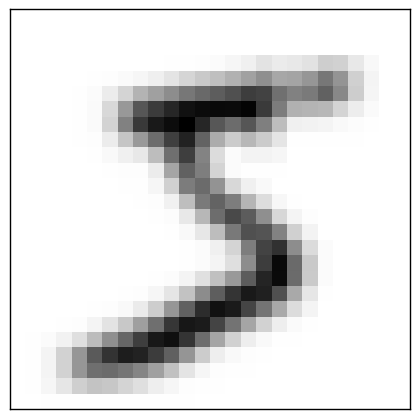

 2392624.84722
   batch: 1 of 1

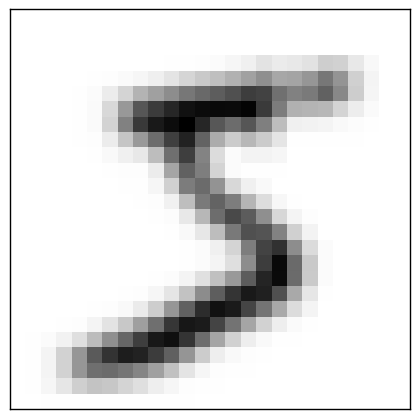

 2654364.42479
   batch: 1 of 1

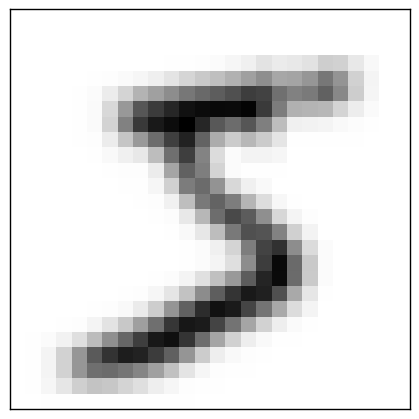

 2929702.20941
   batch: 1 of 1

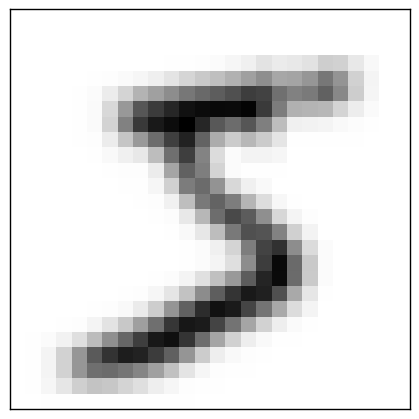

 3218636.1576
   batch: 1 of 1

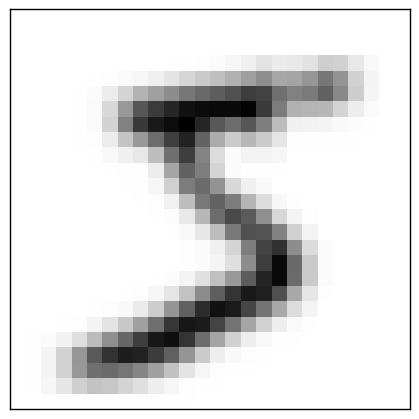

 3521165.68129
   batch: 1 of 1

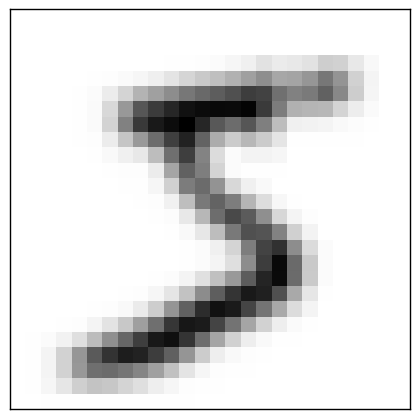

 3837290.95293
   batch: 1 of 1

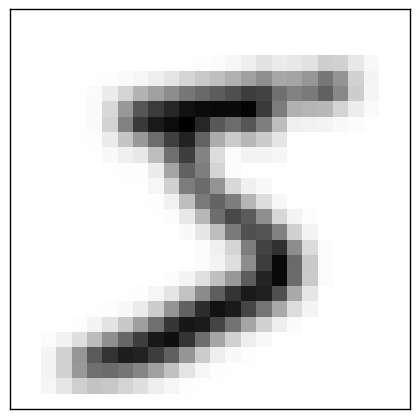

 4167012.28354
   batch: 1 of 1

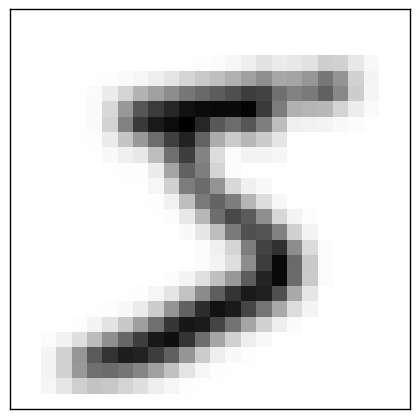

 4510330.73437
   batch: 1 of 1

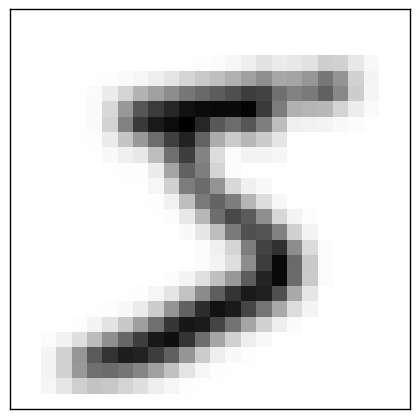

 4867247.36674
   batch: 1 of 1

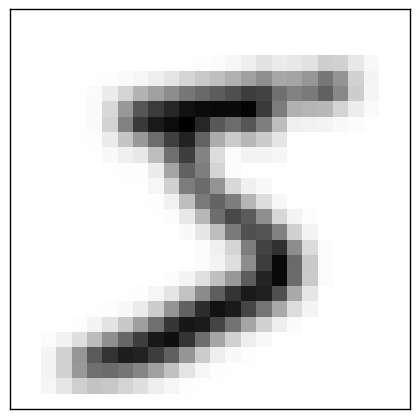

 5237762.3605
   batch: 1 of 1

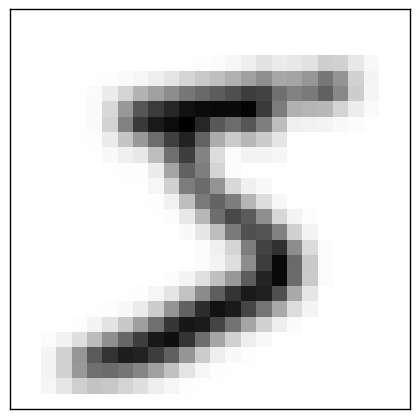

 5621875.96753
   batch: 1 of 1

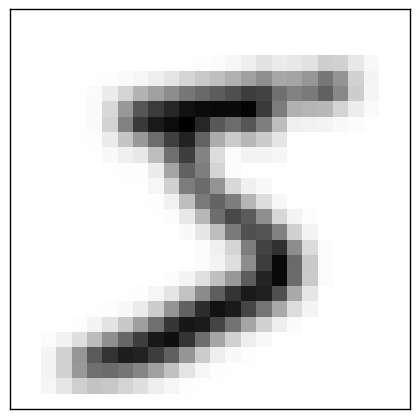

 6019589.01677
   batch: 1 of 1

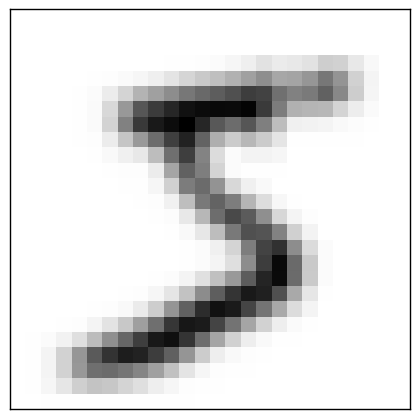

 6430901.32465
   batch: 1 of 1

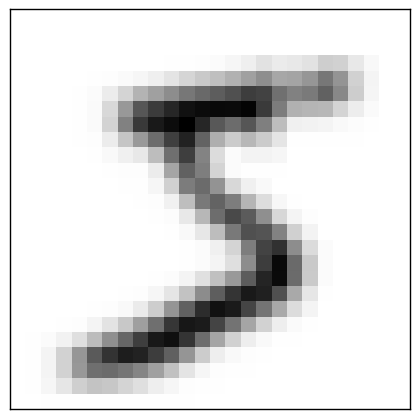

 6855813.28821
   batch: 1 of 1

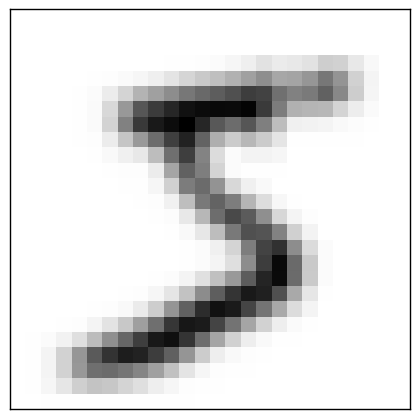

 7294325.04339
   batch: 1 of 1

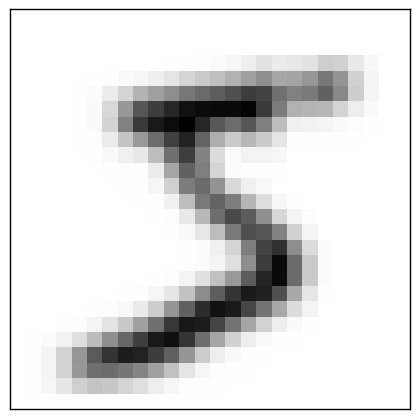

 7746436.37763
   batch: 1 of 1

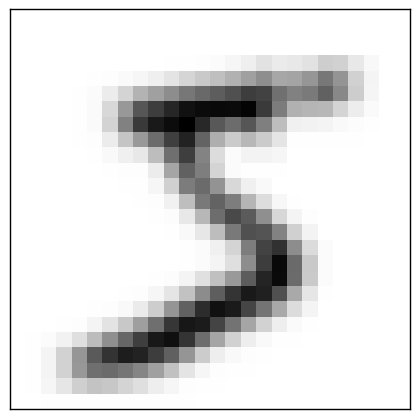

 8212146.94514
   batch: 1 of 1

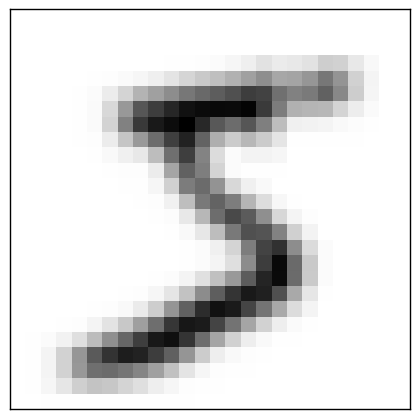

 8691456.48008
   batch: 1 of 1

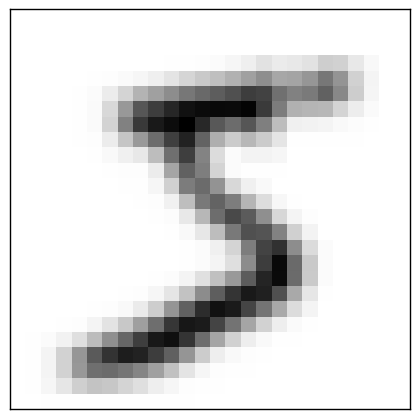

 9184364.83497
   batch: 1 of 1

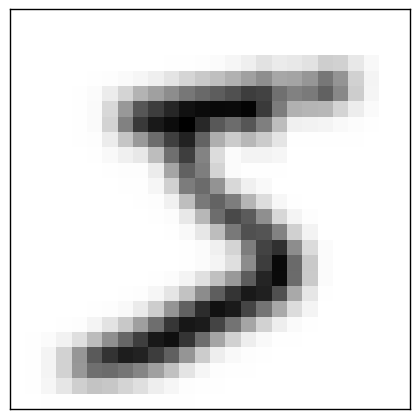

 9690872.42043
   batch: 1 of 1

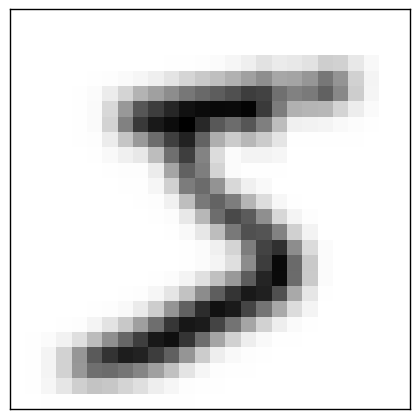

 10210979.3663
   batch: 1 of 1

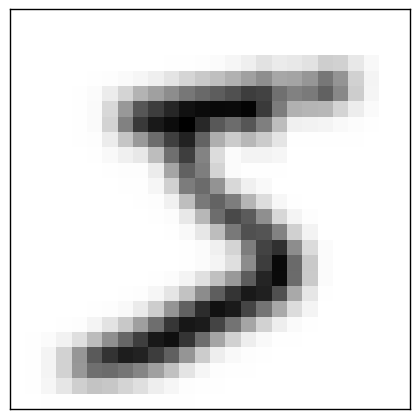

 10744685.2748
   batch: 1 of 1

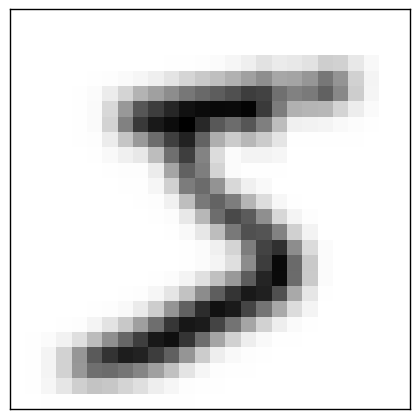

 11291990.4323
   batch: 1 of 1

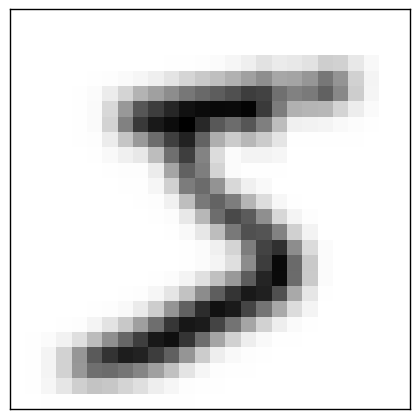

 11852895.1653
   batch: 1 of 1

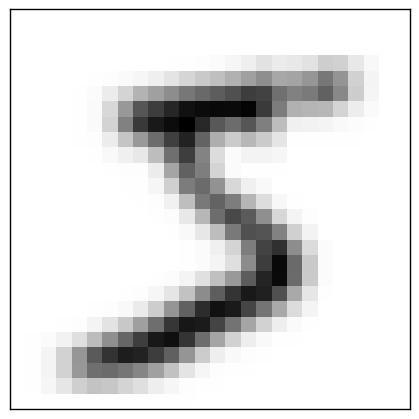

 12427399.8002
   batch: 1 of 1

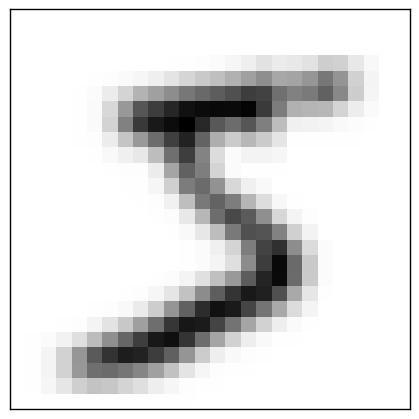

 13015504.6633
   batch: 1 of 1

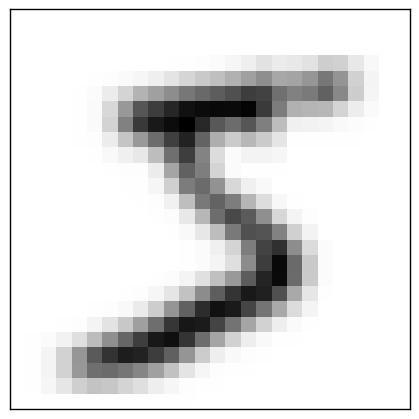

 13617209.793
   batch: 1 of 1

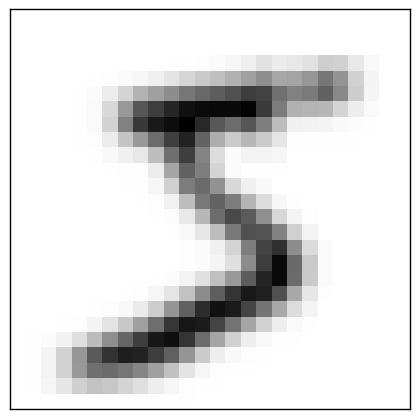

 14232514.0774
   batch: 1 of 1

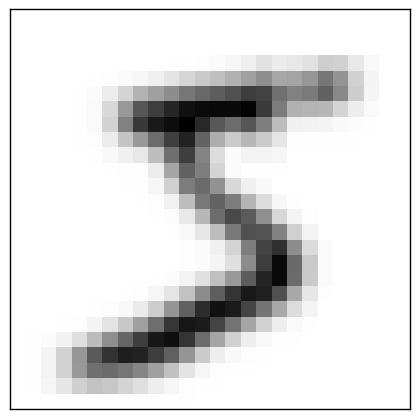

 14861417.5107
   batch: 1 of 1

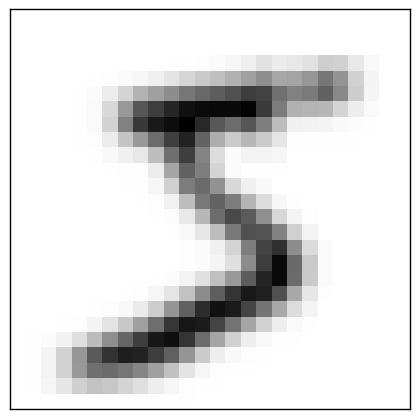

 15503920.2928
   batch: 1 of 1

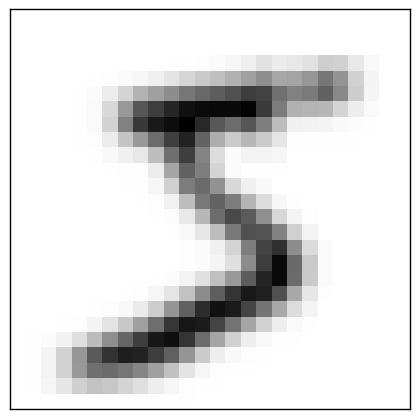

 16160022.6237
   batch: 1 of 1

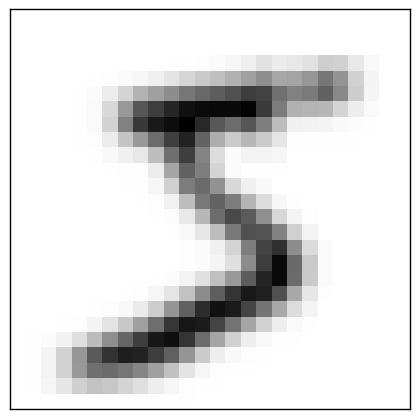

In [25]:
def train_net(epoch=10):
  nn.last_epoch = 0
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=(x[np.newaxis], y[np.newaxis, np.newaxis]),
         batch=1, rate=0.001, 
         epoch_call_back=print_test(),
         epoch=epoch)
    
init()

imshow(nn.get_output(x))
for i in xrange(3):
    train_net(5)
    imshow(nn.get_output(x))

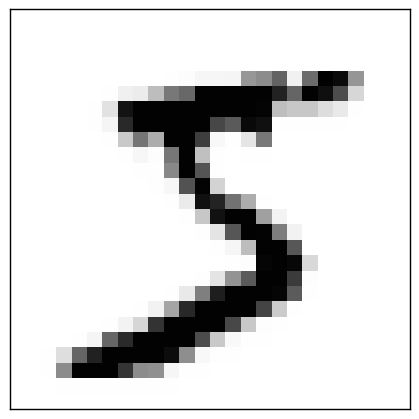

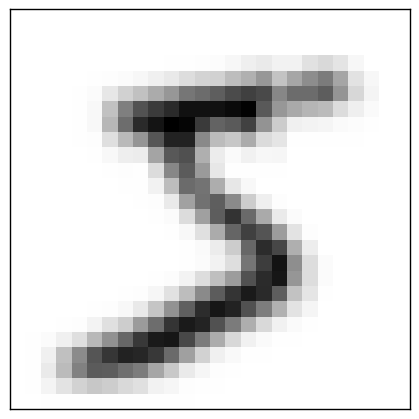

304.214860802
   batch: 1 of 1

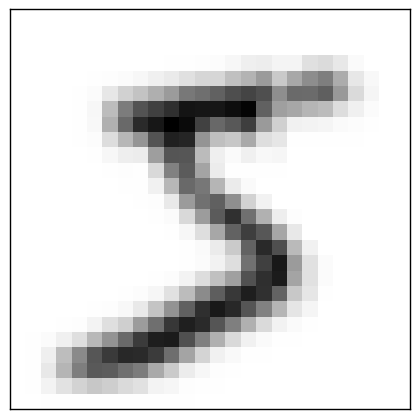

 173.618332746
   batch: 1 of 1

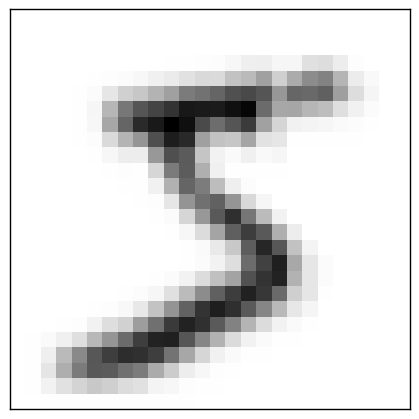

 100.971933849
   batch: 1 of 1

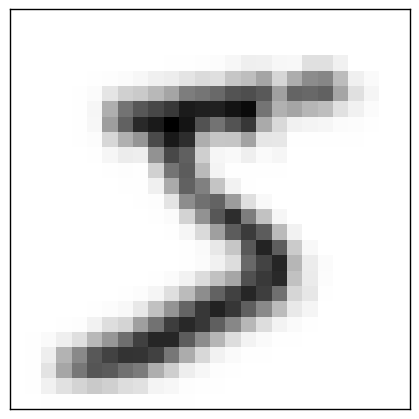

In [31]:
def train_net(epoch=10):
  nn.last_epoch = 0
  nn.SGD(train_policy=nn.fix_epoch,
         training_set=(x[np.newaxis], y[np.newaxis, np.newaxis]),
         batch=1, rate=0.00001, 
         epoch_call_back=print_test(),
         epoch=epoch)
    
init()
imshow(y[None])
imshow(nn.get_output(x))
for i in xrange(3):
    train_net(50)
    imshow(nn.get_output(x))

In [22]:
nn[1].get_output(x).max()

702.11367897037815

In [5]:
print gradtest(1e-10)
DELTA = nn[1].delta
IN = nn[1].input[:,:,:26, :26]

print np.all(convolve2d(nn[1].input[0,0], nn[1].delta[0,0, ::-1, ::-1], 'valid') == p)
print p[0,0,0,0,0]
print (DELTA*IN).sum()

AAAAAAAAAAAAAAAAAAAAA
BBBBBBBBBBBBBBBBBBBBB
191.671460925
True
213.312587865
213.312587865


In [43]:
X = np.random.randint(5, size=(10,10))
K = np.random.randint(5, size=(3,3))
print X[:3,:3]
print K

[[0 0 2]
 [3 2 1]
 [2 3 0]]
[[3 1 2]
 [0 4 4]
 [4 4 0]]


In [51]:
from scipy.signal import convolve2d
X = np.random.randint(5, size=(10,10))
K = np.random.randint(5, size=(3,3))
print "Input's top-left (3x3) corner:"
print X[:3,:3]
print 'Kernel:'
print K

print 'Hardcording the calculation of a valid convolution (top-left)'
print (X[:3,:3]*K[::-1,::-1])
print 'Sums to'
print (X[:3,:3]*K[::-1,::-1]).sum()
print 'However the top-left value of the convolve2d result'
Y = convolve2d(X, K, 'valid')
print Y[0,0]



Input's top-left (3x3) corner:
[[0 4 0]
 [2 3 1]
 [3 3 2]]
Kernel:
[[3 1 1]
 [4 2 4]
 [1 4 0]]
Hardcording the calculation of a valid convolution (top-left)
[[ 0 16  0]
 [ 8  6  4]
 [ 3  3  6]]
Sums to
46
However the top-left value of the convolve2d result
46


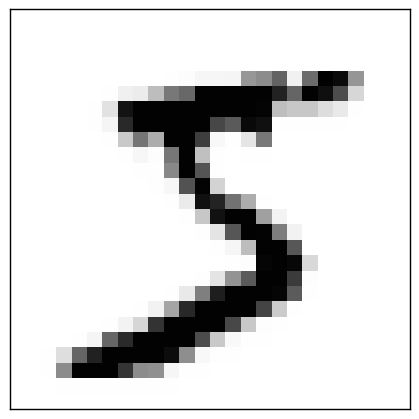

(1, 26, 26)

In [48]:
imshow(y[None])